# Assignment 1

This is my submission for Assignment 1 for my Machine Learning module (CS3920). Below is the core functionality of my machine learning algorithm. I opted to use the nearest neighbour (NN) method and a conformal predictor.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split


iris = load_iris()
iris_label_space = np.array([0,1,2])

ion_X = np.genfromtxt("ionosphere.txt", delimiter=",", usecols=np.arange(34))
ion_y = np.genfromtxt("ionosphere.txt", delimiter=",", usecols=34, dtype="int")
ion_label_space = np.array([1,-1])

iris_X_train, iris_X_test, iris_y_train, iris_y_test = train_test_split(iris['data'], iris['target'], random_state=2408)
ion_X_train, ion_X_test, ion_y_train, ion_y_test = train_test_split(ion_X, ion_y, random_state=2408)


def computeEuclideanNorm(vector: np.ndarray) -> float:
    """
        Computes the Euclidean norm of a vector by adding the squares of each value and square rooting
    """

    total = 0
    for i in range(0,vector.size):
        total += vector[i] * vector[i]
    
    return np.sqrt(total)


def calculateEuclideanDistance(v1: np.ndarray, v2: np.ndarray) -> float: 
    """
        Calculates the Euclidean distance between two points by computing the Euclidean norm of the vector distance
    """
    diff = np.subtract(v1, v2)
    return (computeEuclideanNorm(diff))


def computeDistances(sample: np.ndarray, training_set: np.ndarray) -> np.ndarray:
    """
        Calculates the distances from the given sample to all other points
    """

    result = np.zeros(len(training_set))
    for i in range(0, len(training_set)):
        result[i] = calculateEuclideanDistance(sample, training_set[i])

    return result


def computeMinimum(a: np.ndarray):
    """
        Calculates the minimum value of an array and returns it, along with its index
    """

    current_min = np.inf
    min_index = np.inf
    for n in range(a.size):
        if current_min > a[n]:
            current_min = a[n]
            min_index = n
    
    return current_min, min_index


def computeMaximum(a: np.ndarray):
    """
        Calculates the maximum value of an array and returns it, along with its index
    """
    current_max = -np.inf
    max_index = -np.inf
    for i in range(a.size):
        if current_max < a[i]:
            current_max = a[i]
            max_index = i

    return current_max, max_index


# IMPROVED CALCULATE NNs
def calculateNNs(index: int, sample_y: int, y_training_set: np.ndarray, distances: np.ndarray):
    """
        Calculate the nearest numbers by taking in a matrix of distances
    """
    nn_dist_same = np.inf
    nn_index_same = -1
    nn_dist_diff = np.inf
    nn_index_diff = -1

    for i in range(len(y_training_set)):
        if i == index:
            continue  # skip comparing sample to itself

        dist = distances[index][i]

        if y_training_set[i] == sample_y:
            if dist < nn_dist_same:
                nn_dist_same = dist
                nn_index_same = i
        else:
            if dist < nn_dist_diff:
                nn_dist_diff = dist
                nn_index_diff = i

    return nn_dist_same, nn_index_same, nn_dist_diff, nn_index_diff

def calculateConformityScores(sample_X: np.ndarray, sample_y: np.ndarray, X_training_set: np.ndarray, y_training_set: np.ndarray):
    """
        Calculates the conformity score of a sample, using the NN of the same class / NN of different class.
    """
    X_aug = np.concatenate((sample_X.reshape(1, -1), X_training_set), axis=0)
    y_aug = np.concatenate(([sample_y], y_training_set)) # additional sample will be the FIRST in augmented set

    n = len(X_aug)
    scores = np.zeros(n)

    distances = np.zeros((n, n))
    for i in range(0, n):
        for j in range(i + 1, n):
            dist = calculateEuclideanDistance(X_aug[i], X_aug[j])
            distances[i][j] = dist
            distances[j][i] = dist

    for i in range(0, n):
        nn_dist_same, _, nn_dist_diff, _ = calculateNNs(i, y_aug[i], y_aug, distances)
        
        if nn_dist_same == 0:
            if nn_dist_diff == 0:
                scores[i] = 0
            else:
                scores[i] = np.inf
        else:
            scores[i] =  nn_dist_diff / nn_dist_same

    return scores


def calculatePValue(scores):
    """
        Calculate a given p-value given the conformity scores
    """
    test_score = scores[0]
    other_scores = scores[1:]

    rank = 0
    for score in other_scores:
        if score <= test_score:
            rank += 1

    p_value = (rank + 1) / len(scores)
    return p_value


def predict(Y, sample_X, X_training_set, y_training_set):
    """
        Makes a prediction by computing p-values of all possible labels and selecting the highest one
    """

    Y_size = len(Y)
    p_values = np.zeros(Y_size)
    for i in range (0, Y_size):
        label = Y[i]
        scores = calculateConformityScores(sample_X, label, X_training_set, y_training_set)
        p_values[i] = calculatePValue(scores)

    _, p = computeMaximum(p_values)

    return Y[p]


def score(predictions: np.ndarray, y_test_set: np.ndarray):
    """
        Score the prediction set against the set of actual labels
    """
    return np.mean(predictions == y_test_set)

## Improvements

I noticed using some older implementations of certain algorithms (particularly the NN algorithm) massively impacted running times. Where possible, I tried to implement mitigations to speed up running times.

### Nearest Neighbour Algorithm

Below is an old implementation of my nearest neighbour algorithm.

In [2]:
# OLD IMPLEMENTATION
def calculateNNsOld(sample_X: np.ndarray, sample_y: np.ndarray, X_training_set: np.ndarray, y_training_set: np.ndarray):
    nn_dist_same = np.inf
    nn_index_same = np.inf
    nn_dist_diff = np.inf
    nn_index_diff = np.inf

    for i in range(0,len(X_training_set)):
        if y_training_set[i] == sample_y:
            d = calculateEuclideanDistance(sample_X, X_training_set[i])
            if d < nn_dist_same:
                nn_dist_same = d
                nn_index_same = i
        else:
            d = calculateEuclideanDistance(sample_X, X_training_set[i])
            if d < nn_dist_diff:
                nn_dist_diff = d
                nn_index_diff = i

    # print("Nearest (same):", X_training_set[nn_index_same], "Class:", y_training_set[nn_index_same], "Distance:", nn_dist_same)
    # print("Nearest (diff):", X_training_set[nn_index_diff], "Class:", y_training_set[nn_index_diff], "Distance:", nn_dist_diff)

    return nn_dist_same, nn_index_same, nn_dist_diff, nn_index_diff

I noticed this massively hindered performance as the distances to every other sample were being recalculated every single time, giving $O(n^2)$. I then opted to improve this by using a matrix data structure to store the distances, so that they only need to be computed once, and can be accessed multiple times. This improved running time significantly. Below I will demonstrate an experiment using the old implementation of the `calculateConformityScores` method, and compare it to the new one.

In [3]:
def calculateConformityScoresOld(sample_X, sample_y, X_training_set, y_training_set):
    X_aug = np.concatenate((sample_X.reshape(1, -1), X_training_set), axis=0)
    y_aug = np.concatenate(([sample_y], y_training_set)) # additional sample will be the FIRST in augmented set

    scores = np.zeros(len(y_aug))

    for i in range(0, len(y_aug)):
        X_new = np.delete(X_aug, i, axis=0)
        y_new = np.delete(y_aug, i)
        nn_dist_same, _, nn_dist_diff, _ = calculateNNsOld(X_aug[i], y_aug[i], X_new, y_new)
        conformity_score = 0
        if nn_dist_same == 0:
            if nn_dist_diff == 0:
                conformity_score = 0
            else:
                conformity_score = np.inf
        else:
            conformity_score =  nn_dist_diff / nn_dist_same

        scores[i] = conformity_score

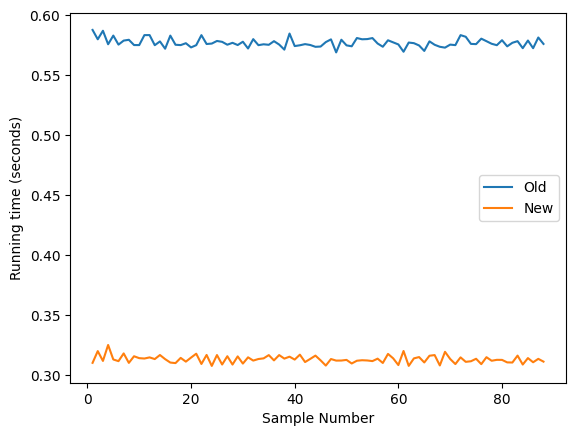

Old implementation completed in average: 0.5770144652236592 seconds
New implementation completed in average: 0.3131999210877852 seconds

Increase in efficiency of new implementation: 54.28%


In [5]:
old_times_ion = np.zeros(len(ion_X_test))
for i in range(0, len(ion_X_test)):
    start_old = time.time()
    calculateConformityScoresOld(ion_X_test[i], ion_y_test[i],ion_X_train, ion_y_train)
    o = time.time() - start_old
    old_times_ion[i] = o

new_times_ion = np.zeros(len(ion_X_test))
for j in range(0,len(ion_X_test)):
    start_new = time.time()
    calculateConformityScores(ion_X_test[0], ion_y_test[0], ion_X_train, ion_y_train)
    n = time.time() - start_new
    new_times_ion[j] = n

x = np.arange(1, len(ion_X_test) + 1) 
plt.plot(x, old_times_ion, label="Old")
plt.plot(x, new_times_ion, label="New")
plt.xlabel("Sample Number")
plt.ylabel("Running time (seconds)")
plt.legend()
plt.show()

print("Old implementation completed in average:", np.mean(old_times_ion), "seconds")
print("New implementation completed in average:", np.mean(new_times_ion), "seconds")

print("\nIncrease in efficiency of new implementation: {:.2f}%".format((np.mean(new_times_ion)/np.mean(old_times_ion)) * 100))


## Calculating the Score of the Model on the Iris Dataset

In [6]:
iris_predictions = np.zeros(len(iris_X_test))
for i in range(0, len(iris_X_test)):
    iris_predictions[i] = predict(iris_label_space, iris_X_test[i], iris_X_train, iris_y_train)

s = score(iris_predictions, iris_y_test)

print("Model Score:", s,"\nError Rate:  {:.2f}%".format((1 - s) * 100))

Model Score: 0.9736842105263158 
Error Rate:  2.63%


## Calculating the Score of the Model on the Ionosphere Dataset

In [7]:
ion_predictions = np.zeros(len(ion_X_test))
for j in range(0, len(ion_X_test)):
    ion_predictions[j] = predict(ion_label_space, ion_X_test[i], ion_X_train, ion_y_train)

s = score(ion_predictions, ion_y_test)

print("Model Score:", s,"\nError Rate:  {:.2f}%".format((1 - s) * 100))

Model Score: 0.6136363636363636 
Error Rate:  38.64%


## Error Rates vs Sample Size

Here I will perform some experiments to determine how the sample size affects the error rate of the model.

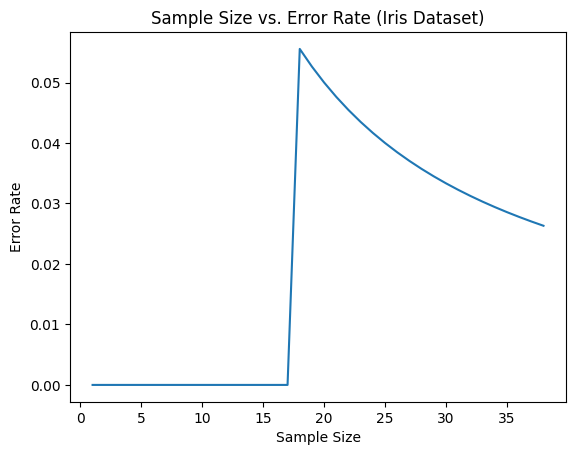

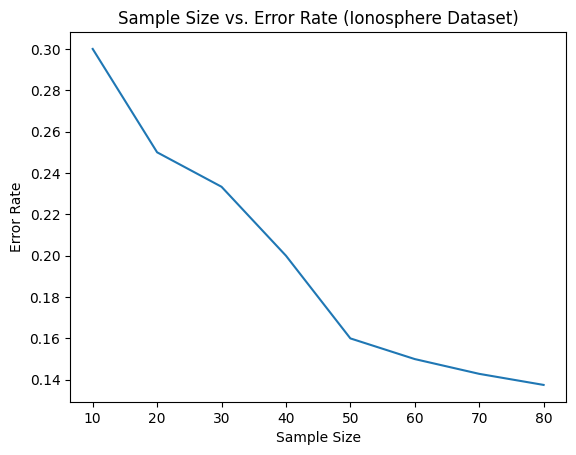

In [13]:
iris_sizes = np.arange(1, len(iris_X_test) + 1)
ion_sizes = np.arange(10, len(ion_X_test) + 1, 10)

iris_error_rates = []
ion_error_rates = []

def testErrorRates(label_space, X_test, X_train, y_test, y_train, sizes):
    error_rates = []
    for size in sizes:
        temp_x_test = X_test[:size]
        temp_y_test = y_test[:size]
        predictions = np.zeros(size)
        for i in range(0,size):
            predictions[i] = predict(label_space, temp_x_test[i], X_train, y_train)

        error = 1 - score(predictions, temp_y_test)
        error_rates.append(error)

    return error_rates

iris_error_rates = testErrorRates(iris_label_space, iris_X_test, iris_X_train, iris_y_test, iris_y_train, iris_sizes)
ion_error_rates = testErrorRates(ion_label_space, ion_X_test, ion_X_train, ion_y_test, ion_y_train, ion_sizes)

plt.plot(iris_sizes, iris_error_rates)
plt.title("Sample Size vs. Error Rate (Iris Dataset)")
plt.xlabel("Sample Size")
plt.ylabel("Error Rate")
plt.show()

plt.plot(ion_sizes, ion_error_rates)
plt.title("Sample Size vs. Error Rate (Ionosphere Dataset)")
plt.xlabel("Sample Size")
plt.ylabel("Error Rate")
plt.show()

## Calculating the Average False P-Values

Before calculating the average false p-values for both datasets, I will first lay out the function I am going to use to do this. The function takes in the $X$ and $y$ training sets, as well as the label space $Y$ and the true label for the sample. The function works on a sample-by-sample basis, so for each sample it calculates the average false p-values. It does this by checking if the label we are currently calculating a p-value for is the *true* label. If so, we can skip it. If not, we calculate the conformity scores, the p_value, and add it to the list of p-values. From this, we simply calculate the average using `np.mean`.

In [ ]:
def calculateAverageFalsePValues(Y, sample_X, X_training_set, y_training_set, true_y):
    Y_size = len(Y)
    false_p_values = []
    
    for i in range (0, Y_size):
        label = Y[i]
        if label != true_y:
            scores = calculateConformityScores(sample_X, label, X_training_set, y_training_set)
            p_value = calculatePValue(scores)
            false_p_values.append(p_value)

    return np.mean(false_p_values)

We can now apply this function to the Iris dataset.

In [ ]:
total_false_p_values = np.zeros(len(iris_X_test))
for i in range(0,len(iris_X_test)):
    total_false_p_values[i] = calculateAverageFalsePValues(iris_label_space, iris_X_test[i], iris_X_train, iris_y_train, iris_y_test[i])

print("Total average false p-value:", np.mean(total_false_p_values))

Total average false p-value: 0.011178388448998605


And now the same for the Ionosphere dataset.

In [ ]:
total_false_p_values = np.zeros(len(ion_X_test))
for i in range(0,len(ion_X_test)):
    total_false_p_values[i] = calculateAverageFalsePValues(ion_label_space, ion_X_test[i], ion_X_train, ion_y_train, ion_y_test[i])

print("Total average false p-value:", np.mean(total_false_p_values))

Total average false p-value: 0.0625
